In [4]:
import networkx as nx
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, QuadExpr

# Network edges and resistances
edges = [(1, 2), (1, 3), (2, 3), (2, 4), (3, 4)]
resistance = {(1, 2): 1, (1, 3): 4, (2, 3): 6, (2, 4): 12, (3, 4): 3}

# Nodes
nodes = [1, 2, 3, 4]
source = 1
sink = 4
flow_demand = 710

# Create a Gurobi model
model = Model("Power_Loss_Minimization")

# Variables: Current on each edge
I = model.addVars(edges, lb=-GRB.INFINITY, vtype=GRB.CONTINUOUS, name="I")

# Objective: Minimize total power loss
objective = QuadExpr()
for (i, j) in edges:
    objective += resistance[(i, j)] * I[i, j] * I[i, j]  # R * I^2
model.setObjective(objective, GRB.MINIMIZE)

# Constraints: Flow conservation at each node
for node in nodes:
    inflow = sum(I[i, j] for i, j in edges if j == node)  # Incoming current
    outflow = sum(I[i, j] for i, j in edges if i == node)  # Outgoing current

    # Apply flow conservation
    if node == source:
        model.addConstr(outflow - inflow == flow_demand, name=f"flow_conservation_source_{node}")
    elif node == sink:
        model.addConstr(outflow - inflow == -flow_demand, name=f"flow_conservation_sink_{node}")
    else:
        model.addConstr(outflow - inflow == 0, name=f"flow_conservation_{node}")

# Solve the model
model.optimize()

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.4.0 23E224)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4 rows, 5 columns and 10 nonzeros
Model fingerprint: 0xdfa0db5b
Model has 5 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e+00, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+02, 7e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.01s
Presolved: 3 rows, 5 columns, 7 nonzeros
Presolved model has 5 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 5
 AA' NZ     : 2.000e+00
 Factor NZ  : 6.000e+00
 Factor Ops : 1.400e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   2.09802387e+06 -2.09802387e+06  1.71


Optimal solution found:
Optimized Power Loss: 2031910.77 watts
Current on edge (1, 2): 371.38 amps
Current on edge (1, 3): 338.62 amps
Current on edge (2, 3): 163.85 amps
Current on edge (2, 4): 207.54 amps
Current on edge (3, 4): 502.46 amps


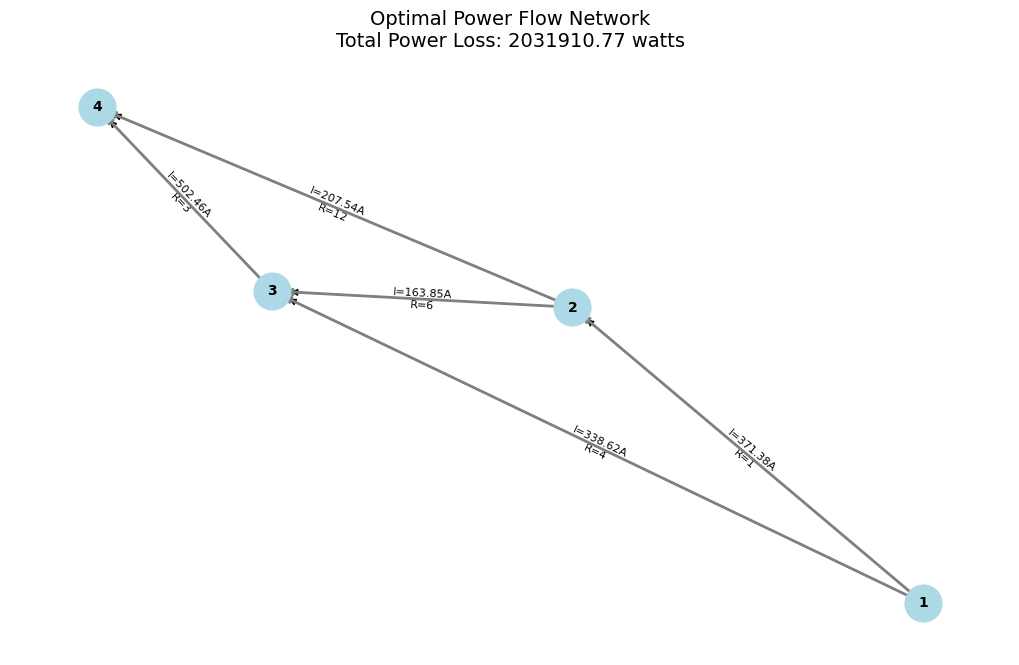

In [10]:
# Check solution status
if model.status == GRB.OPTIMAL:
    print("\nOptimal solution found:")
    total_power_loss = model.ObjVal
    print(f"Optimized Power Loss: {total_power_loss:.2f} watts")

    # Extract optimal currents
    flow_values = {edge: I[edge].X for edge in edges}

    # Display the optimal current on each edge
    for (i, j), flow in flow_values.items():
        print(f"Current on edge ({i}, {j}): {flow:.2f} amps")

    # Visualization with networkx
    G = nx.DiGraph()

    # Add nodes
    for node in nodes:
        G.add_node(node)

    # Add edges with flow values
    for (i, j), flow in flow_values.items():
        G.add_edge(i, j, weight=flow, resistance=resistance[(i, j)])

    # Draw the graph
    pos = nx.spring_layout(G)  # Layout for visualization
    edge_labels = {(i, j): f"I={flow:.2f}A\nR={resistance[(i, j)]}" for (i, j), flow in flow_values.items()}

    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, node_size=700, node_color="lightblue", font_size=10, font_weight="bold")
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    nx.draw_networkx_edges(G, pos, width=2, edge_color="gray")
    plt.title(f"Optimal Power Flow Network\nTotal Power Loss: {total_power_loss:.2f} watts", fontsize=14)
    plt.show()
else:
    print("No optimal solution found.")